In [476]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

In [477]:
# abrimos el documento utilizando Pandas
#eph_total = pd.read_excel("usu_individual_T423.xlsx")

In [478]:
eph = eph_total.copy() # para no tener que importar el excel cada vez porque tarda 20 segundos
print(eph.shape)

(47337, 177)


# PARTE 1

## Ejercicio 2.a) dejar CABA y GBA

In [479]:
# buscamos quedarnos con CABA y GBA, por lo que los valores dentro de 'aglomerado' deben ser 32 y 33
# eliminamos los que no cumplan esta condicion
eph = eph[eph['AGLOMERADO'].isin([32, 33])].reset_index(drop=True)
eph.shape
# Notamos que ahora pasamos de 47337 obs a 7380 obs

(7380, 177)

## Ejercicio 2.b) Outliers

In [480]:
antes = eph.shape[0]
print("observaciones antes de eliminar outliers:", eph.shape[0])

# las columnas que vamos a chequear si tiene outliers:
# son columnas que deberian ser positivas sino no tienen sentido
columnas = ['CH06',       # edad
              'PP08D1',   # ingresos de asalariados
              'PP06C',    # ingresos de independientes sin cuentas de asociados
              'PP06D',    # ingresos de independientes con cuentas de asociados
              'ITF',      # Ingreso total familiar
              'IPCF']     # Ingreso per capita familiar

# esta función toma un numero y los valores negativos los convierte en NA
# es para aplicarla con .apply() a cada columna despues
def outliers(val):
  if val < 0:
    return "borrar"
  else:
    return val

# Convermitmos en el string "borrar" los valores que no tienen sentido
for col in columnas:
  eph[col] = eph[col].apply(outliers)

# eliminamos los outliers que identificamos como "borrar"

# esto encuentra los indices de las filas que tienen el string "borrar" y los dropea
eph = eph.drop(np.where(eph.applymap(lambda x: x == 'borrar').any(axis=1))[0])

eph.reset_index(drop=True, inplace=True)


print("despues:", eph.shape[0])
print("se eliminaron:", antes-eph.shape[0], "observaciones")

observaciones antes de eliminar outliers: 7380
despues: 6360
se eliminaron: 1020 observaciones


## Ejercicio 2.c) Histograma por sexo

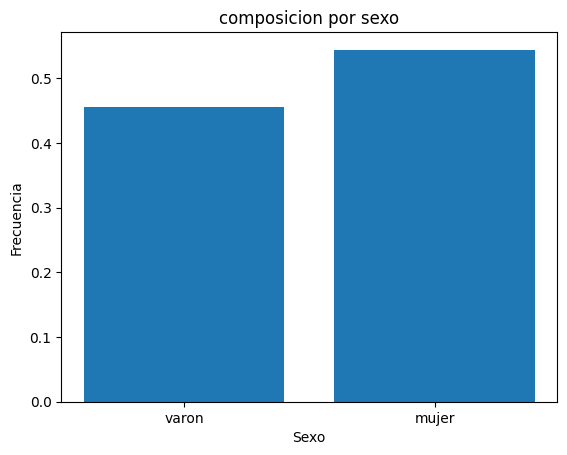

In [481]:
# guardamos la frecuencia de cada sexo
freq_dict = {'varon': 0, 'mujer': 0}
for item in eph['CH04']:
  if item == 1:
    freq_dict['varon'] += 1
  elif item == 2:
    freq_dict['mujer'] += 1

# computamos la proporcion de varones y de mujeres
freq_dict['varon'] = freq_dict['varon'] / len(eph['CH04'])
freq_dict['mujer'] = freq_dict['mujer'] / len(eph['CH04'])

# hacemos el histograma con matplot
plt.bar(list(freq_dict.keys()), list(freq_dict.values()))
plt.xlabel('Sexo')
plt.ylabel('Frecuencia')
plt.title('composicion por sexo')
plt.show()

## Ejercicio 2.d) Matriz de Correlación

<Figure size 700x700 with 0 Axes>

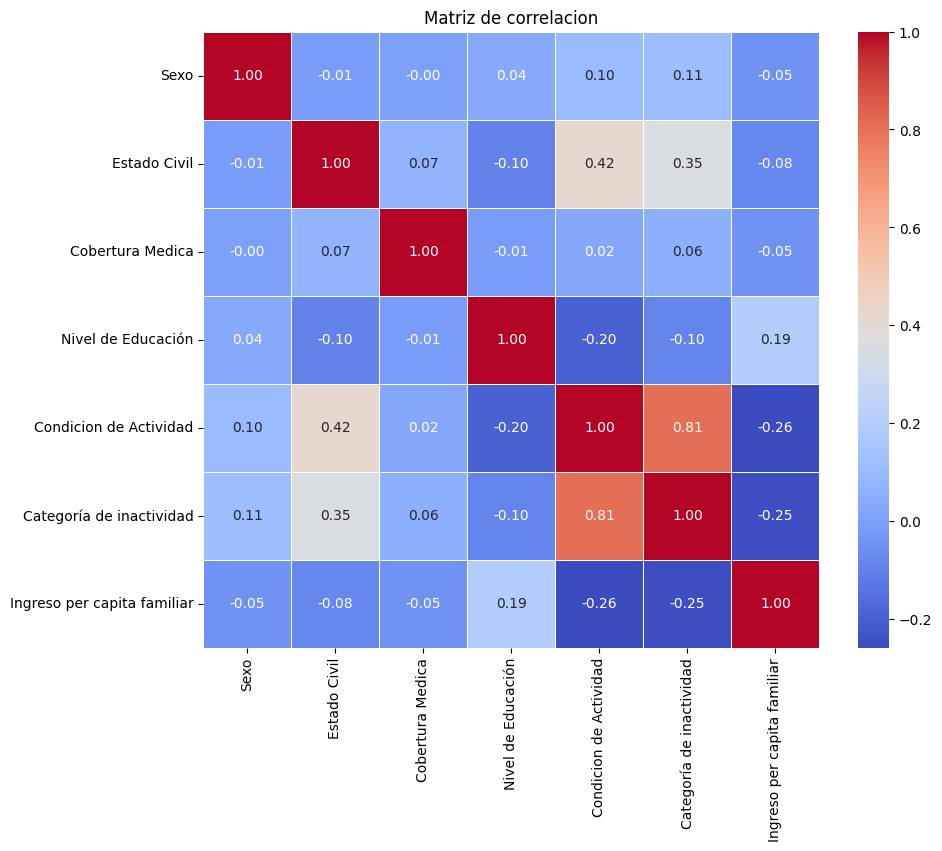

In [482]:
plt.figure(figsize=(7, 7))
eph_2 = eph[['CH04', 'CH07', 'CH08', 'NIVEL_ED', 'ESTADO', 'CAT_INAC', 'IPCF']]
eph_2 = eph_2.rename(columns={
    'CH04': 'Sexo',
    'CH07': 'Estado Civil',
    'CH08': 'Cobertura Medica',
    'NIVEL_ED': 'Nivel de Educación',
    'ESTADO': 'Condicion de Actividad',
    'CAT_INAC': 'Categoría de inactividad',
    'IPCF': 'Ingreso per capita familiar'
})
corr = eph_2.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)
plt.title('Matriz de correlacion')
plt.show()

## Ejercicio 2.e) Descripción de la base

In [483]:
print(f"La cantidad de desocupados en la muestra es de {len(eph[eph['ESTADO'] == 2])}")
print(f"La cantidad de inactivos en la muestra es de {len(eph[eph['ESTADO'] == 3])}")
print(f"La media del ingreso per capita familiar para activos es {np.mean(eph['IPCF'][eph['ESTADO'] == 1]):.2f}")
print(f"La media del ingreso per capita familiar para desocupados es {np.mean(eph['IPCF'][eph['ESTADO'] == 2]):.2f}")
print(f"La media del ingreso per capita familiar para inactivos es {np.mean(eph['IPCF'][eph['ESTADO'] == 3]):.2f}")

La cantidad de desocupados en la muestra es de 240
La cantidad de inactivos en la muestra es de 2765
La media del ingreso per capita familiar para activos es 182038.68
La media del ingreso per capita familiar para desocupados es 58012.20
La media del ingreso per capita familiar para inactivos es 84993.68


## Ejercicio 2.f) Adulto equivalente
Agregamos en la base eph una columna 'ad_equiv_hogar' 

In [484]:
# leemos el documento y acomodamos el nombre de las columnas
ad_equiv = pd.read_excel("tabla_adulto_equiv.xlsx")
ad_equiv.rename(columns={'Tabla de equivalencias de necesidades energéticas. Unidades de adulto equivalente, según sexo y edad': 'edad', 
                         'Unnamed: 1': 'mujeres', 
                         'Unnamed: 2': 'varones'}, 
                inplace=True)

# borramos las columnas que no necesitamos
ad_equiv.drop([0,1,2,3,27,28,29,30,31,32,33,34,35,36,37,38], inplace=True)
ad_equiv.reset_index(drop=True, inplace=True)

# generamos en la base de eph la columna de necesidades energeticas
eph['adulto_equiv'] = np.nan


# agarramos en cada rango de edades descrito como string el comienzo y el final del rango
# esta funcion rango le das un string y crea una lista con los numeros que haya en ese string
def rangos(s):             
    num_str = ''
    edades = []
    for car in s:
        if car.isdigit():
            num_str += car
        elif num_str:
            edades.append(int(num_str))
            num_str = ''
    if num_str:
        edades.append(int(num_str))
    return edades

# hacemos que la columna de strings que describen los rangos sea una columna de listas
ad_equiv['edad'] = ad_equiv['edad'].apply(rangos)

# hacemos que cada lista tenga dos elementos, comienzo y final, tal que los lea python (1 más que el valor final)
for r in ad_equiv['edad']:
    if len(r) == 1:
        r.append(r[-1] + 1)
    else:
        r[-1] += 1

ad_equiv.loc[0, 'edad'][0],  ad_equiv.loc[0, 'edad'][1]= 0, 1   # corregimos el primer rango
ad_equiv.loc[ad_equiv.index[-1], 'edad'][-1] = 150              # el ultimo rango lo hacemos hasta 150


# asignamos las necesidades electricas a la columna de eph
for index, row in ad_equiv.iterrows():
    age_list = list(range(row['edad'][0], row['edad'][1]))
    for sex, column in [(1, 'varones'), (2, 'mujeres')]:
        # aca asigna en 'adulto_equiv' los que cumpla la condicion de su respectiva edad y sexo
        eph.loc[(eph['CH06'].isin(age_list)) & (eph['CH04'] == sex), 'adulto_equiv'] = row[column]


Ahora para cada hogar sumamos los valores de adulto equivalente de los miembros del hogar

In [485]:
eph = eph.assign(ad_equiv_hogar=eph.groupby('CODUSU')['adulto_equiv'].transform('sum'))
eph[['ad_equiv_hogar', 'CODUSU', 'CH06']]

,ad_equiv_hogar,CODUSU,CH06
0,1.37,TQRMNOTUUHJMLPCDEIIAD00801670,76
1,1.37,TQRMNOTUUHJMLPCDEIIAD00801670,79
2,5.64,TQRMNOPUUHJKLQCDEIIAD00793187,65
3,5.64,TQRMNOPUUHJKLQCDEIIAD00793187,66
4,2.82,TQRMNOPUTHKLMNCDEIIAD00791268,49
...,...,...,...
6355,2.43,TQRMNOSRQHLMNSCDEIJAH00855730,39
6356,2.43,TQRMNOSRQHLMNSCDEIJAH00855730,7
6357,2.52,TQRMNOVTYHLMNUCDEIJAH00855731,67
6358,2.52,TQRMNOVTYHLMNUCDEIJAH00855731,67


## Ejercicio 3
Dividimos la base de datos eph en dos: 'respondieron' y 'norespondieron

In [486]:
respondieron=eph[eph['ITF'] != 0].reset_index(drop=True)
respondieron['ITF']
norespondieron=eph[eph['ITF']==0].reset_index(drop=True)
print(f"La cantidad de personas que no respondieron cual es su ingreso familiar es {len(eph[eph['ITF']==0])}")
print(" obs en norespondieron", norespondieron.shape[0], "\n", 
      "obs en respondieron", respondieron.shape[0], "\n",
      "check: suma de ambas =", respondieron.shape[0]+norespondieron.shape[0], ", total =",  eph.shape[0])

La cantidad de personas que no respondieron cual es su ingreso familiar es 2005
 obs en norespondieron 2005 
 obs en respondieron 4355 
 check: suma de ambas = 6360 , total = 6360


## Ejercicio 4
Agregamos a la base respondieron la columna 'ingreso_necesario'

In [487]:
respondieron['ingreso_necesario'] = np.nan
ingreso_por_adulto= 132853.3
respondieron['ingreso_necesario'] = respondieron['ad_equiv_hogar'] * ingreso_por_adulto
respondieron[['ingreso_necesario', 'ITF', 'CODUSU']]

,ingreso_necesario,ITF,CODUSU
0,182009.021,450000,TQRMNOTUUHJMLPCDEIIAD00801670
1,182009.021,450000,TQRMNOTUUHJMLPCDEIIAD00801670
2,374646.306,800000,TQRMNOPUTHKLMNCDEIIAD00791268
3,374646.306,800000,TQRMNOPUTHKLMNCDEIIAD00791268
4,374646.306,800000,TQRMNOPUTHKLMNCDEIIAD00791268
...,...,...,...
4350,322833.519,800000,TQRMNOSRQHLMNSCDEIJAH00855730
4351,322833.519,800000,TQRMNOSRQHLMNSCDEIJAH00855730
4352,334790.316,240000,TQRMNOVTYHLMNUCDEIJAH00855731
4353,334790.316,240000,TQRMNOVTYHLMNUCDEIJAH00855731


## Ejercicio 5
en la base 'respondieron' agregamos una columna 'pobre'

In [488]:
respondieron['pobre'] = np.nan
respondieron['pobre'] = 0
respondieron.loc[respondieron['ITF'] < respondieron['ingreso_necesario'], 'pobre'] = 1
print(" pobres entre los que respondieron:", len(respondieron[respondieron['pobre']==1]), "\n",
      "no pobres entre los que respondieron:", len(respondieron[respondieron['pobre']==0]))

 pobres entre los que respondieron: 1738 
 no pobres entre los que respondieron: 2617
